In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Capstone_Object_Detection/script/Capstone_Fall2024/')
!pwd

/content/drive/MyDrive/Capstone_Object_Detection/script/Capstone_Fall2024


In [3]:
!ls

bdd100k_dataloader.py	    github	      python-greene	    scripts
bdd10k_dataloader.py	    gitignore	      raft		    train_video_info_new.npy
eval_copy_detection.py	    hubconf.py	      README.md		    utils.py
eval_image_retrieval.py     LICENSE	      run_ood_train.sh	    video_generation.py
eval_knn.py		    main_dino.py      run.sh		    vision_transformer.py
eval_linear.py		    ood_detection.py  run_with_submitit.py  visualize_attention.py
eval_video_segmentation.py  __pycache__       script.ipynb	    wt_dataloader.py


In [4]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 100.3 MB/s eta 0:00:00


In [ ]:
import argparse
import os
import sys
import datetime
import time
import logging
import math
import json
from pathlib import Path

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models

from bdd100k_dataloader import BDD100KDataset
from bdd10k_dataloader import ImageFolderWithoutLabels
from wt_dataloader import WalkingToursDataset
import utils
import vision_transformer as vits
from vision_transformer import DINOHead

from ood_detection import OODDetector, MemoryBuffer

In [ ]:
# class DataAugmentationDINO(object):
#     def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
#         flip_and_color_jitter = transforms.Compose([
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomApply(
#                 [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
#                 p=0.8
#             ),
#             transforms.RandomGrayscale(p=0.2),
#         ])
#         normalize = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#         ])

#         # first global crop
#         self.global_transfo1 = transforms.Compose([
#             # transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
#             transforms.RandomResizedCrop((512, 1024), ratio=(1.5, 2.5), scale=global_crops_scale, interpolation=Image.BICUBIC),
#             flip_and_color_jitter,
#             utils.GaussianBlur(1.0),
#             normalize,
#         ])
#         # second global crop
#         self.global_transfo2 = transforms.Compose([
#             # transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
#             transforms.RandomResizedCrop((512, 1024), ratio=(1.5, 2.5), scale=global_crops_scale, interpolation=Image.BICUBIC),
#             flip_and_color_jitter,
#             utils.GaussianBlur(0.1),
#             utils.Solarization(0.2),
#             normalize,
#         ])
#         # transformation for the local small crops
#         self.local_crops_number = local_crops_number
#         self.local_transfo = transforms.Compose([
#             # transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
#             transforms.RandomResizedCrop((224, 448), ratio=(1.5, 2.5), scale=local_crops_scale, interpolation=Image.BICUBIC),
#             flip_and_color_jitter,
#             utils.GaussianBlur(p=0.5),
#             normalize,
#         ])

#     def __call__(self, image):
#         crops = []
#         crops.append(self.global_transfo1(image))
#         crops.append(self.global_transfo2(image))
#         for _ in range(self.local_crops_number):
#             crops.append(self.local_transfo(image))
#         return crops

In [ ]:
# prompt: write a show image functio with a tensor as the inpute. Remember to change the float tensor to int. Also, the pic is normalized using             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), so you need to inv_norm it

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_image(tensor):
    # Assuming the tensor is normalized with the given mean and std
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Inverse normalize the tensor
    tensor = inv_normalize(tensor)

    # Convert tensor to numpy array and change data type to int
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = (image * 255).astype(np.uint8)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
import random
from torchvision.transforms import functional as F
from PIL import Image

class DataAugmentationDINO_BDD10K(object):
    def __init__(self, global_crops_scale = (0.3, 1), local_crops_scale = (0.1, 0.3), local_crops_number = 6):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # Transformations for global views
        self.global_crops_scale = global_crops_scale
        self.local_crops_scale = local_crops_scale
        self.local_crops_number = local_crops_number

        # First global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            #flip_and_color_jitter,
            #utils.GaussianBlur(1.0),
            normalize,
        ])

        # Second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            #flip_and_color_jitter,
            #utils.GaussianBlur(0.1),
            #utils.Solarization(0.2),
            normalize,
        ])

        # Transformations for local views
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            normalize,
        ])

    def _random_crop_with_overlap(self, image, size, scale, reference_crop=None):
        """
        Perform a random crop with control for overlap with a reference crop.
        """
        w, h = image.size
        crop_scale = random.uniform(*scale)
        crop_w, crop_h = int(w * crop_scale), int(h * crop_scale)

        if reference_crop:
            # Ensure overlap by aligning crop with reference region
            ref_x, ref_y, ref_w, ref_h = reference_crop
            x = random.randint(max(0, ref_x - crop_w // 2), min(w - crop_w, ref_x + ref_w // 2))
            y = random.randint(max(0, ref_y - crop_h // 2), min(h - crop_h, ref_y + ref_h // 2))
        else:
            # Fully random crop
            x = random.randint(0, w - crop_w)
            y = random.randint(0, h - crop_h)

        return image.crop((x, y, x + crop_w, y + crop_h)).resize(size, Image.BICUBIC)

    def __call__(self, image):
        random.seed(42)
        crops = []

        # Generate first global crop
        global_crop1 = self.global_transfo1(image)
        crops.append(global_crop1)

        # Generate overlapping second global crop
        global_crop1_coords = (0, 0, image.width, image.height)  # Placeholder for actual global crop 1 bounds
        global_crop2 = self._random_crop_with_overlap(image, (224, 224), self.global_crops_scale, global_crop1_coords)
        crops.append(self.global_transfo2(global_crop2))

        # Generate local crops with partial overlap with global views
        for _ in range(self.local_crops_number):
            local_crop = self._random_crop_with_overlap(image, (96, 96), self.local_crops_scale, global_crop1_coords)
            crops.append(self.local_transfo(local_crop))

        return crops

In [ ]:
transform_new = DataAugmentationDINO_BDD10K()

In [ ]:
# Use the custom dataset class
dataset = ImageFolderWithoutLabels('/content/drive/MyDrive/Capstone_Object_Detection/Dataset/images/10k/train', transform=transform_new)

# Set up the DataLoader
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    num_workers=12,
    pin_memory=True,
    drop_last=True,
)
dataset_len = len(dataset)

In [ ]:
from scipy.spatial import distance
from numpy.linalg import pinv

class OODDetectorNew:
    def __init__(self, device, weights_path=None, threshold=0.95):
        """
        Initialize the OOD Detector.
        """
        self.device = device
        self.threshold = threshold

        # Resize transform to ensure images are 224x224
        self.resize_transform = transforms.Compose([
            transforms.Resize((224, 224)),
        ])

        # Load the ResNet backbone
        if weights_path is None:
            self.encoder = self.load_default_dino_weights()
        else:
            self.encoder = torchvision_models.resnet50(pretrained=False)
            self.load_dino_weights(weights_path)

        self.encoder.eval()
        self.encoder = self.encoder.to(self.device)

        # Placeholders for dataset stats
        self.mean_vector = None
        self.threshold_value = None
        self.cov_inv = None

    def compute_dataset_stats(self, sampled_dataset):
        """
        Compute mean vector, inverse covariance, and Mahalanobis threshold from a sampled dataset.
        """
        with torch.no_grad():
            all_features = []
            for image in sampled_dataset:
                image = self.resize_transform(image).to(self.device)
                features = self.encoder(image.unsqueeze(0)).detach().squeeze()
                all_features.append(features)

            features_matrix = torch.stack(all_features)
            features_matrix = features_matrix.mean(dim=(2, 3))
            #features_matrix = features_matrix[:, :256]
            print(features_matrix.shape)
            self.mean_vector = features_matrix.mean(dim=0, keepdim=True)
            #cov_matrix = torch.cov(features_matrix.T)
            #cov_matrix = torch.clamp(cov_matrix, min=0)
            #cov_matrix += 1e-5 * torch.eye(cov_matrix.shape[0], device=cov_matrix.device)
            #print('cov det checkig:', np.linalg.det(cov_matrix.cpu()))
            #self.cov_inv = torch.inverse(cov_matrix)
            #self.cov_inv = torch.tensor(pinv(cov_matrix.cpu().numpy()), device=self.mean_vector.device)

            #diff, cov_inv, distances = self.compute_mahalanobis_distance(features_matrix, self.mean_vector, self.cov_inv)
            #distances = [distance.mahalanobis(arr.cpu().flatten(), self.mean_vector.cpu().flatten(), self.cov_inv.cpu()) for arr in features_matrix]
            distances = [distance.euclidean(arr.cpu().flatten(), self.mean_vector.cpu().flatten()) for arr in features_matrix]
            dist_tensor = torch.Tensor(distances)
            #dist_tensor = torch.nan_to_num(torch.Tensor(distances), nan=1e6)
            #print(dist_tensor)
            nan_count = torch.isnan(dist_tensor).sum().item()
            print(f"Number of NaN values: {nan_count}")

            self.threshold_value = torch.nanquantile(dist_tensor, self.threshold).item()
            print(f"Computed threshold: {self.threshold_value}")
            #print('diff:', diff)
            #print('cov_inv:', torch.min(cov_inv))

    def detect(self, images):
        """
        Identify rare samples using Mahalanobis distance for batches of global and local views.
        """
        #global_image = [images[i][j] for i in range(batch_size) for j in [0,1]]
        #global_image = [images[j][i] for i in range(batch_size) for j in [0,1]]
        global_image = [images[j][i] for i in range(len(images[0])) for j in [0,1]]

        images_resized = [self.resize_transform(image).to(self.device) for image in global_image]
        images_resized = torch.stack(images_resized)

        print("Reshaped images_resized:", images_resized.shape)

        with torch.no_grad():
            features = self.encoder(images_resized).detach()
            features = features.mean(dim=(2, 3))
            #features = features[:, :256]
            #distances = self.compute_mahalanobis_distance(features, self.mean_vector, self.cov_inv)
            #distances = [distance.mahalanobis(arr.cpu().flatten(), self.mean_vector.cpu().flatten(), self.cov_inv.cpu()) for arr in features]
            distances = [distance.euclidean(arr.cpu().flatten(), self.mean_vector.cpu().flatten()) for arr in features]
            nan_count = torch.isnan(torch.Tensor(distances)).sum().item()
            print(f"Number of NaN values: {nan_count}")
            dist_tensor = torch.nan_to_num(torch.Tensor(distances), nan=1e6)

            #print(dist_tensor)
            rare_indices = (dist_tensor > self.threshold_value).nonzero(as_tuple=True)[0]

        return torch.unique(rare_indices // 2)

    def load_default_dino_weights(self):
        """
        Load the default DINO ResNet50 (ImageNet-pretrained).
        """
        print("Loading default DINO ResNet50 weights from torch.hub...")
        model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        model = torch.nn.Sequential(*(list(model.children())[:-2]))  # Use up to the second-last layer
        return model

    def extract_features(self, image_tensor):
        with torch.no_grad():
          feature_map = self.encoder(image_tensor.unsqueeze(0).to(self.device)).squeeze(0)  # Shape: (2048, 7, 7)
          feature_vector = feature_map.mean(dim=(1, 2))  # Shape: (2048,)
        return feature_vector.cpu().numpy()

    def load_dino_weights(self, weights_path):
        """
        Load weights for the ResNet backbone from a DINO checkpoint.

        Args:
        - weights_path (str): Path to the .pth file.
        """
        print(f"Loading DINO weights from: {weights_path}")
        checkpoint = torch.load(weights_path, map_location=self.device)
        if "teacher" in checkpoint:
            resnet_weights = checkpoint["teacher"]  # DINO-specific weight structure
            state_dict = {k.replace("backbone.", ""): v for k, v in resnet_weights.items() if "backbone" in k}
            self.encoder.load_state_dict(state_dict, strict=False)
        else:
            raise ValueError("Invalid checkpoint structure for DINO. Expected 'teacher' key.")

    ### @staticmethod
    # def compute_mahalanobis_distance(features, mean, cov_inv):
    #     """
    #     Compute Mahalanobis distance for given features.

    #     Args:
    #     - features (torch.Tensor): Feature vectors (N x D).
    #     - mean (torch.Tensor): Mean vector (1 x D).
    #     - cov_inv (torch.Tensor): Inverse covariance matrix (D x D).

    #     Returns:
    #     - distances (torch.Tensor): Mahalanobis distances (N).
    #     """
    #     diff = features - mean
    #     dist = torch.sqrt(torch.sum(diff @ cov_inv * diff, dim=1))
    #     dist = torch.sqrt(torch.matmul(diff, torch.matmul(inv_cov_matrix, diff.T)))

    #     return diff, cov_inv, dist


class MemoryBuffer:
    def __init__(self, max_size = 32):
        self.buffer = deque(maxlen=max_size)

    def add(self, samples):
        """
        Add new rare samples to the buffer.
        """
        self.buffer.extend(samples)

    def get(self):
        """
        Get all samples from the buffer for training.
        """
        return list(self.buffer)

    def concat_with_batch(self, batch):
        """
        Concatenate the buffer with the current training batch.
        """
        return batch + self.get()

    def clear(self):
        """
        Clear the memory buffer.
        """
        self.buffer.clear()

In [ ]:
for tmp_sample in data_loader:
  #print(sample.shape)
  break

In [ ]:
tmp_global_detect.shape

torch.Size([128, 3, 224, 224])

In [ ]:
ood.detect([tmp_sample[0], tmp_sample[1]])

Reshaped images_resized: torch.Size([64, 3, 224, 224])
Number of NaN values: 0
tensor([3.3919, 3.0618, 3.0854, 3.7936, 3.7733, 3.1328, 2.8507, 3.4749, 2.9327,
        3.2329, 2.5431, 3.1037, 3.3351, 3.7575, 3.1541, 2.8719, 2.7275, 3.7479,
        4.0674, 5.2933, 3.9183, 4.0575, 3.5401, 3.7885, 4.2394, 4.0788, 3.3108,
        3.5062, 3.4969, 3.8754, 4.0875, 4.5534, 2.7837, 2.8105, 3.7826, 3.7365,
        3.9173, 3.9130, 3.9233, 4.2508, 2.8617, 3.1696, 4.1064, 3.9526, 2.8215,
        2.8045, 3.5706, 3.3223, 2.6183, 2.8020, 3.7667, 3.9063, 3.3017, 3.1424,
        3.6714, 3.5797, 3.7775, 3.9999, 3.4859, 3.0988, 3.9006, 4.4839, 3.6726,
        3.7617])


tensor([ 9, 15, 30])

In [ ]:
[torch.concat([tmp_sample[0], tmp_sample[0]]) ]

torch.Size([64, 3, 224, 224])

In [ ]:
len(tmp_sample + tmp_sample)

16

In [ ]:
images = []
for im in tmp_sample:
    if len(im.shape) == 5:
        im = im.flatten(0, 1)
    images.append(im.to('cuda', non_blocking=True))

In [ ]:
images[0].shape

torch.Size([32, 3, 224, 224])

In [ ]:
batch_size = 64
tmp_global_compute_threshold = [dataset[i][j] for i in range(batch_size) for j in [0,1]]
test_batch_size = 64
tmp_global_detect = [dataset[i][j] for i in range(1024, 1024+test_batch_size) for j in [0,1]]
tmp_global_detect = torch.stack(tmp_global_detect)

In [ ]:
ood = OODDetectorNew(device = 'cuda')
ood.compute_dataset_stats(tmp_global_compute_threshold)

Loading default DINO ResNet50 weights from torch.hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([128, 2048])
tensor([3.2497, 3.1915, 3.2391, 3.4207, 3.0623, 3.1196, 3.1273, 3.2084, 3.5744,
        3.1698, 2.7223, 3.3604, 4.1022, 3.1190, 3.2540, 2.9355, 3.0766, 3.5858,
        3.5612, 3.9931, 3.8828, 3.8770, 3.6194, 3.5638, 4.3650, 4.1557, 3.1784,
        3.6134, 2.9604, 3.6881, 4.0695, 4.3892, 2.8897, 2.9309, 3.9300, 3.4089,
        5.3097, 3.9987, 4.0553, 4.3955, 2.7208, 3.3308, 4.4055, 3.6299, 2.6927,
        2.8441, 3.5669, 3.3189, 2.5721, 2.9319, 4.0221, 3.6650, 3.0680, 3.1164,
        3.6950, 3.6151, 3.6051, 3.8678, 3.1251, 3.4121, 3.6263, 3.9783, 3.5711,
        3.9459, 3.7792, 3.0404, 2.9927, 2.5358, 3.3433, 5.1652, 3.7881, 3.4470,
        2.5534, 3.4503, 3.7564, 3.5472, 3.1047, 3.2458, 4.0946, 4.2518, 3.1376,
        2.7204, 3.2764, 4.3937, 2.5961, 2.6755, 3.6850, 3.4119, 3.7958, 3.4316,
        3.0158, 2.9637, 3.0889, 3.9154, 4.3865, 4.4644, 3.3363, 3.1725, 3.1846,
        3.7253, 3.9437, 3.3951, 3.8157, 3.3549, 3.1251, 3.7728, 3.1848, 2.7952,
        4.2049, 

In [ ]:
# reconstruct = [tmp_global_detect[::2], tmp_global_detect[1::2]]
# print(len(tmp_global_compute_threshold))
# print(reconstruct[0].shape)

In [ ]:
#ood_idx = ood.detect(reconstruct, batch_size=test_batch_size)
# ood_idx = ood.detect([torch.stack(tmp_global_compute_threshold)[::2],
#                       torch.stack(tmp_global_compute_threshold)[1::2]])
ood_idx = ood.detect([tmp_global_detect[::2],
                      tmp_global_detect[1::2]])

Reshaped images_resized: torch.Size([128, 3, 224, 224])
Number of NaN values: 0
tensor([3.9366, 3.9723, 4.7239, 4.5369, 3.1574, 3.9002, 3.7507, 3.3811, 3.1762,
        2.6334, 2.9674, 2.7086, 3.6115, 2.8321, 2.8110, 2.7766, 2.7727, 2.7966,
        2.8137, 3.0592, 3.3769, 2.9943, 3.9672, 3.9454, 3.7063, 3.9240, 3.3192,
        2.8028, 4.7938, 4.6964, 3.4419, 3.2749, 2.9592, 3.7371, 3.6541, 3.3848,
        3.5846, 3.7303, 3.4786, 2.9960, 3.4726, 3.6734, 2.9814, 2.7206, 3.6494,
        4.2465, 3.8177, 4.0422, 3.2769, 3.1294, 3.4924, 3.2224, 3.2304, 4.1225,
        4.7950, 3.7935, 3.6666, 4.5729, 4.5398, 4.5714, 4.5353, 4.8418, 3.2393,
        3.0936, 4.6312, 4.3017, 3.8438, 3.4556, 3.7092, 3.1689, 3.0667, 3.5876,
        3.4953, 3.6301, 4.3095, 4.6337, 3.2034, 3.0962, 2.9286, 2.9849, 2.9147,
        3.4985, 4.0546, 4.2432, 2.8275, 4.0453, 4.6924, 3.8584, 4.0104, 3.6279,
        3.1782, 3.0982, 3.0451, 3.6163, 3.8741, 3.9575, 2.7495, 2.7555, 4.6206,
        3.8609, 3.9033, 4.1579, 2.8427, 

In [ ]:
tmp_global_detect

In [ ]:
dataset[]

In [ ]:
dataset[1024 + ood_idx[0]][2].shape

torch.Size([3, 96, 96])

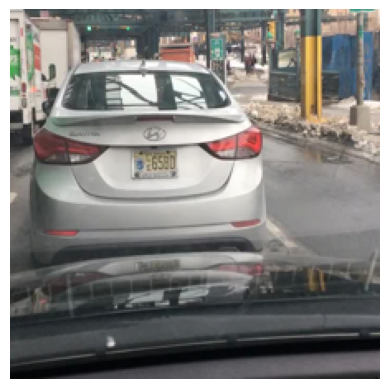

In [ ]:
show_image(dataset[1024 + ood_idx[0]][0])

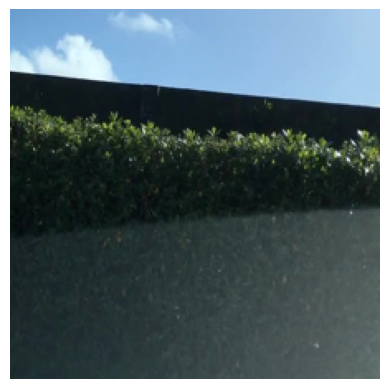

In [ ]:
show_image(tmp_global_detect[ood_idx[10]*2])

In [ ]:
tmp_global_detect.shape

torch.Size([512, 3, 224, 224])

In [ ]:
ood_idx

tensor([ 32,  43,  54,  62,  67, 124, 130, 141, 163, 166, 176, 182, 191, 211,
        228, 230, 238])